In [2]:
from visuals import WAVELENGTHS
from pca_helper import *

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import os
from osgeo import gdal
import sys
from spectral.io import envi

In [4]:
def pixel_geo_coords(dx,dy, raster):
    px = raster.GetGeoTransform()[0]
    py = raster.GetGeoTransform()[3]
    rx = raster.GetGeoTransform()[1]
    ry = raster.GetGeoTransform()[5]
    x = dx*rx + px
    y = dy*ry + py
    return x,y

In [5]:
import concurrent

def pixel_geo_coords(dx,dy, raster):
    px = raster.GetGeoTransform()[0]
    py = raster.GetGeoTransform()[3]
    rx = raster.GetGeoTransform()[1]
    ry = raster.GetGeoTransform()[5]
    x = dx*rx + px
    y = dy*ry + py
    return x,y

def get_coords(file):
    raster = gdal.Open(file)
    # raster_envi = envi.open(file + '.hdr').open_memmap(interleave='bip')

    step_size = 50
    valid_array = []
    index_coords = []
    utm_coords = []
    for x in range(0, raster.RasterXSize-step_size, step_size):
        for y in range(0, raster.RasterYSize-step_size, step_size):
            arr = raster.ReadAsArray(xoff=x, yoff=y, xsize=step_size, ysize=step_size)
            # arr = raster_envi[y:y+step_size,x:x+step_size,:].copy()
            try:
                if abs(sum(sum(arr))) != step_size*step_size:

                    index_coords.append({'xoff':x, 'yoff':y, 'step':step_size})
                    upper_left_coords, lower_right_coords = pixel_geo_coords(x, y, raster), pixel_geo_coords(x+step_size, y+step_size, raster)
                    utm_coords.append((upper_left_coords, lower_right_coords))
                    valid_array.append(arr)
            except Exception:
                raise Exception
                
    return index_coords, valid_array


def thread_rfl(map_indices):
    start_index, end_index = map_indices['indices']
    index_coords = map_indices['index_coords']
    valid_array = map_indices['valid_array']
    # gdals = map_indices['gdals']
    file_names = map_indices['file_names']
    
    dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
    this_complete_pixels = []
    step_size = 50
    
    complete_pixels = dict(zip(dates, [np.array([]) for d in dates]))
    for i, coords in enumerate(index_coords[start_index: end_index]):
        i = i + start_index
        
        v = valid_array[i]
        v = np.transpose(v, (1,0))
        
        valid_indices = np.where(v == 0)
        
        rfls = []
        for j, date in enumerate(dates):
            rfl = envi.open(file_names[j] + '.hdr').open_memmap(interleave='bip')[coords['yoff']:coords['yoff']+step_size,coords['xoff']:coords['xoff']+step_size,:].copy()
            # print('Obtined RFL:', date, i)
            rfl = np.transpose(rfl, (1,0,2))
            # temp_rfl = rfl.copy()

            
            rfl = rfl[valid_indices]

            if len(complete_pixels[date]) == 0:
                complete_pixels[date] = rfl
            else:
                complete_pixels[date] = np.concatenate([complete_pixels[date], rfl], axis=0)
            rfls.append(rfl)
            
#             if i <5:
#                 print("rfl shape", temp_rfl.shape)
#                 fig = plt.figure(figsize = (12, 7))
#                 r = temp_rfl[:,:,54]
#                 g = temp_rfl[:,:,34]
#                 b = temp_rfl[:,:,16]
#                 img = np.dstack((r, g, b))
#                 plt.imshow(img);

#                 v = valid_array[i]
#                 v = np.transpose(v, (1,0))
#                 c = abs(v)
#                 z = np.ones((v.shape[0],v.shape[1]))
#                 img = np.dstack((c, z, z))
#                 plt.imshow(img, alpha = 0.3);


        print(str(i)+"/"+str(len(index_coords)))
        
    return complete_pixels


def get_rfls(file):
    
    index_coords, valid_array = get_coords(file)
    print("Obtained Coords")
    
    dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
    file_names = [f"/beegfs/scratch/makiper/Mosaics/flight_products/{date}/box_mosaics/box_rfl_phase_l2a" for date in dates]
    complete_pixels = []

    # gdals = []
    # for date in dates:
    #     gdals.append(gdal.Open(f"/beegfs/scratch/makiper/Mosaics/flight_products/{date}/box_mosaics/box_rfl_phase_l2a"))
        
    with concurrent.futures.ThreadPoolExecutor() as executer:
        index_step = 2
        indices = [(index, index+index_step if index+index_step < len(index_coords) else len(index_coords)) for index in range(0, len(index_coords), index_step)]
        print(indices)
        # enter_list = [{'indices':i, 'index_coords':index_coords, 'valid_array':valid_array, 'gdals':gdals} for i in indices]
        enter_list = [{'indices':i, 'index_coords':index_coords, 'valid_array':valid_array, 'file_names':file_names} for i in indices]
        
        results = executer.map(thread_rfl, enter_list)

        for result in results:
            complete_pixels.append(result)
        
    return complete_pixels        
        
        
    

In [6]:
file = "/home/makiper/Data/surface_types/cover_raster_mining.tif"
raster = gdal.Open(file)
print(f"X: {raster.RasterXSize}, Y: {raster.RasterYSize}, Z: {raster.RasterCount}")
# raster_envi = envi.open(file).open_memmap(interleave='bip')

X: 13739, Y: 12023, Z: 1


In [7]:
# CAN DO ABOVE OR BELOW
step_size = 50
valid_array = []
index_coords = []
utm_coords = []
for x in range(0, raster.RasterXSize-step_size, step_size):
    for y in range(0, raster.RasterYSize-step_size, step_size):
        arr = raster.ReadAsArray(xoff=x, yoff=y, xsize=step_size, ysize=step_size)
        try:
            if abs(sum(sum(arr))) != step_size*step_size:
                # TODO: DFS alg on extracting exact shape
                
                index_coords.append({'xoff':x, 'yoff':y, 'step':step_size})
                upper_left_coords, lower_right_coords = pixel_geo_coords(x, y, raster), pixel_geo_coords(x+step_size, y+step_size, raster)
                utm_coords.append((upper_left_coords, lower_right_coords))
                valid_array.append(arr)
        except Exception:
            raise Exception

In [8]:
y, dy = index_coords[0]['yoff'], index_coords[0]['yoff']+index_coords[0]['step']
x, dx = index_coords[0]['xoff'], index_coords[0]['xoff']+index_coords[0]['step']

file = "/beegfs/scratch/makiper/Mosaics/flight_products/20220224/box_mosaics/box_rfl_phase_l2a"
rfl = envi.open(file + '.hdr').open_memmap(interleave='bip')[y:dy, x:dx, :].copy()
rfl = np.transpose(rfl, (1,0,2))

# rfl_2 = gdal.Open("/beegfs/scratch/makiper/Mosaics/flight_products/20220224/box_mosaics/box_rfl_phase_l2a")
# rfl_2 = rfl_2.ReadAsArray(xoff=x, yoff=y, xsize=index_coords[0]['step'], ysize=index_coords[0]['step'])
# rfl_2 = np.transpose(rfl_2, (2, 1,0))

# mining_rfls[0]['20220224']

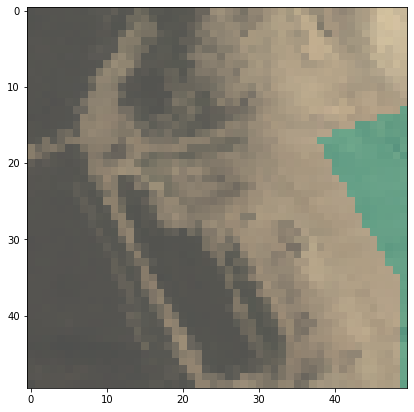

In [9]:
fig = plt.figure(figsize = (12, 7))
r = rfl[:,:,54]
g = rfl[:,:,34]
b = rfl[:,:,16]
img = np.dstack((r, g, b))
plt.imshow(img);

v = valid_array[0]
v = np.transpose(v, (1,0))
c = abs(v)
z = np.ones((v.shape[0],v.shape[1]))
img = np.dstack((c, z, z))
plt.imshow(img, alpha = 0.3);

In [10]:
index_coords

[{'xoff': 3300, 'yoff': 6600, 'step': 50},
 {'xoff': 3300, 'yoff': 6650, 'step': 50},
 {'xoff': 3350, 'yoff': 6600, 'step': 50},
 {'xoff': 3350, 'yoff': 6650, 'step': 50}]

In [11]:
total_rfls_20220224 = np.array([])
for i in range(len(index_coords)):
    y, dy = index_coords[i]['yoff'], index_coords[i]['yoff']+index_coords[i]['step']
    x, dx = index_coords[i]['xoff'], index_coords[i]['xoff']+index_coords[i]['step']

    file = "/beegfs/scratch/makiper/Mosaics/flight_products/20220224/box_mosaics/box_rfl_phase_l2a"
    rfl = envi.open(file + '.hdr').open_memmap(interleave='bip')[y:dy, x:dx, :].copy()
    rfl = np.transpose(rfl, (1,0,2))
    
    v = valid_array[i]
    v = np.transpose(v, (1,0))
    valid_indices = np.where(v == 0)
    
    rfl = rfl[valid_indices]
    
    if len(total_rfls_20220224) == 0:
        total_rfls_20220224 = rfl
    else:
        total_rfls_20220224 = np.concatenate([total_rfls_20220224, rfl], axis=0)

In [18]:
np.count_nonzero(total_rfls_20220224 != total_rfls['20220224']) # compare to the dataset ran below to make sure they're correct

0

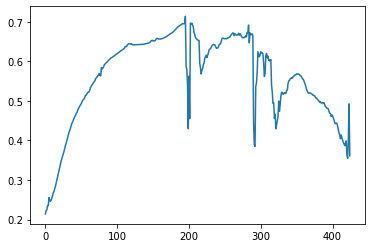

In [12]:
plt.plot(np.mean(total_rfls_20220224, axis=0));

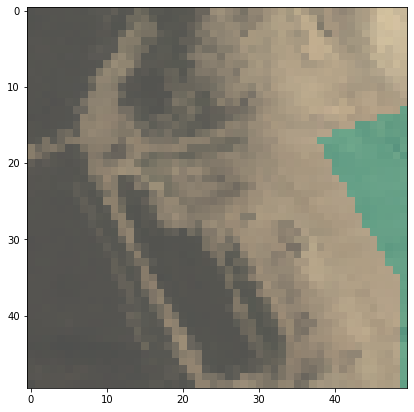

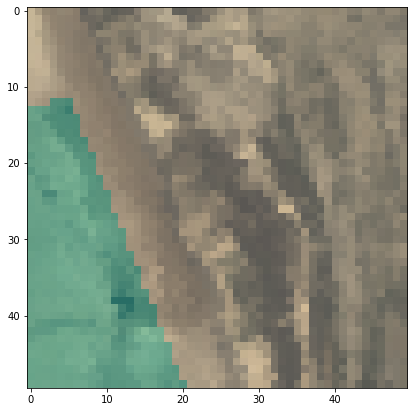

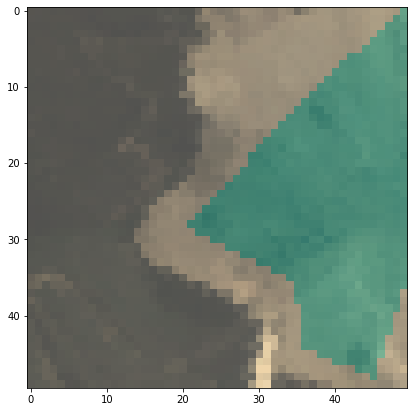

In [13]:
file = "/beegfs/scratch/makiper/Mosaics/flight_products/20220224/box_mosaics/box_rfl_phase_l2a"
# rfls = gdal.Open(file)
rfls = envi.open(file +'.hdr').open_memmap(interleave='bip')

overlay = True

# def flip(arr):
#     new_arr = 

for i, coords in enumerate(index_coords[:3]):
    y, dy = coords['yoff'], coords['yoff']+coords['step']
    x, dx = coords['xoff'], coords['xoff']+coords['step']
    rfl = envi.open(file + '.hdr').open_memmap(interleave='bip')[y:dy, x:dx,:].copy()
    # this_arr = rfls.ReadAsArray(xoff=coords['xoff'], yoff=coords['yoff'], xsize=coords['step'], ysize=coords['step'])
    # this_arr = np.array(this_arr).T
    # this_arr = np.fliplr(this_arr)
    # this_arr = np.rot90(this_arr, k=1, axes=(0,1))
    this_arr = np.transpose(rfl, (1,0,2))
    
    fig = plt.figure(figsize = (12, 7))
    r = this_arr[:,:,54]
    g = this_arr[:,:,34]
    b = this_arr[:,:,16]
    img = np.dstack((r, g, b))
    plt.imshow(img);
    # plt.plot(this_arr[10][10]);
    
    if overlay:
        v = valid_array[i]
        v = np.transpose(v, (1,0))
        c = abs(v)
        z = np.ones((v.shape[0],v.shape[1]))
        img = np.dstack((c, z, z))
        plt.imshow(img, alpha = 0.3);

In [14]:
mining_rfls = get_rfls("/home/makiper/Data/surface_types/cover_raster_mining.tif")

Obtained Coords
[(0, 2), (2, 4)]
0/4
2/4
1/4
3/4


In [15]:
total_rfls = {}

for item in mining_rfls:
    for date in list(mining_rfls[0].keys()):
        if date not in total_rfls.keys():
            total_rfls[date] = item[date]
        else:
            total_rfls[date] = np.concatenate([total_rfls[date], item[date]], axis = 0)

In [16]:
total_rfls['20220224'].shape

(2216, 425)

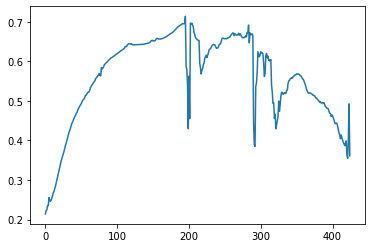

In [17]:
plt.plot(np.mean(total_rfls['20220224'], axis=0));

In [19]:
bad_pix = dict(zip([date for date in total_rfls.keys()], [[] for d in total_rfls.keys()]))
for date in total_rfls.keys():
    for i, rfl in enumerate(total_rfls[date]):
        if -9999 in list(rfl):
            bad_pix[date].append(i)

In [20]:
total_rfls_corrected = {}
for date in total_rfls.keys():
    bad_indices = bad_pix[date]
    good_indces = [i for i in range(total_rfls['20220224'].shape[0]) if i not in bad_indices]
    total_rfls_corrected[date] = np.array(total_rfls[date])[good_indces]
    

In [21]:
for date in total_rfls_corrected.keys():
    print(total_rfls_corrected[date].shape)

(2216, 425)
(2216, 425)
(2216, 425)
(2216, 425)
(0, 425)
(2216, 425)
(2216, 425)
(2216, 425)
(2216, 425)
(2216, 425)
(2216, 425)
(0, 425)
(2216, 425)


In [129]:
# bad_rfls = []
# for date in total_rfls.keys():
#     for i, rfl in enumerate(total_rfls[date]):
#         if -9999 in rfl:
#             if i not in bad_rfls and len(np.where(rfl<0)[0])>5:
#                 bad_rfls.append(i)
#             else:
#                 indices = np.where(rfl<0)[0]
#                 for ind in indices:
#                     if ind-1>0 and ind+1<425:
#                         avg = np.mean([rfl[ind-1], rfl[ind+1]])
#                         rfl[ind] = avg
#                         total_rfls[date][i] = rfl
                
# len(bad_rfls), total_rfls['20220224'].shape

(87, (130, 425))

In [130]:
# total_rfls_corrected = {}
# good_indices = [i for i in range(total_rfls['20220224'].shape[0]) if i not in bad_rfls]
# for date in total_rfls.keys():
#     total_rfls_corrected[date] = np.array(total_rfls[date])[good_indices]

In [22]:
with open("/home/makiper/Notebooks/true_mining_rfls_corrected.pickle", "wb") as f:
    pickle.dump(total_rfls_corrected, f)

In [6]:
with open("/home/makiper/Notebooks/true_mining_rfls_corrected.pickle", "rb") as f:
    total_rfls_corrected = pickle.load(f)

In [179]:
altered_rfl_dict = {}
for key, val in total_rfls_corrected.items():
    if key != '20220322' and key != '20220517':
        altered_rfl_dict[key] = val[:, indices]
print(altered_rfl_dict['20220224'].shape)

num_dates = len(altered_rfl_dict.keys())
series_dates = [create_raw_time_series(altered_rfl_dict, i, remove_bands=False) for i in range(num_dates)] # water bands already removed

(2216, 335)
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-05 00:00:00 | 2022-03-27 00:00:00 | 9
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  

In [200]:
series_dates_corrected = np.array([np.array(sorted(list(dates[0]))) for dates in series_dates])
series_dates_corrected = list(zip(series_dates_corrected, [i[1] for i in series_dates]))
series_dates_corrected

/tmp/ipykernel_232817/248466279.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  series_dates_corrected = np.array([np.array(sorted(list(dates[0]))) for dates in series_dates])


[(array(['20220224'], dtype='<U8'), nan),
 (array(['20220224', '20220529'], dtype='<U8'), 94.0),
 (array(['20220224', '20220412', '20220529'], dtype='<U8'), 47.0),
 (array(['20220224', '20220405', '20220429', '20220529'], dtype='<U8'),
  31.333333333333332),
 (array(['20220224', '20220316', '20220412', '20220503', '20220529'],
        dtype='<U8'),
  23.5),
 (array(['20220224', '20220316', '20220405', '20220420', '20220511',
         '20220529'], dtype='<U8'),
  18.8),
 (array(['20220224', '20220308', '20220405', '20220412', '20220429',
         '20220511', '20220529'], dtype='<U8'),
  15.666666666666666),
 (array(['20220224', '20220308', '20220316', '20220405', '20220420',
         '20220503', '20220511', '20220529'], dtype='<U8'),
  13.428571428571429),
 (array(['20220224', '20220308', '20220316', '20220405', '20220412',
         '20220420', '20220503', '20220511', '20220529'], dtype='<U8'),
  11.75),
 (array(['20220224', '20220308', '20220316', '20220405', '20220412',
         '2022

In [182]:
with open("/home/makiper/Notebooks/mining_noise_2.pickle", "rb") as f:
    m_noise = pickle.load(f)
corrected_noise = np.diag(m_noise)

In [184]:
from pca_items.intrinsic_dimension import IntrinsicDimensionRMT as ID
from visuals import WAVELENGTHS
from pca_helper import *

def thread_id(s):
    i, series = s[0], s[1]
    print("Starting Series: ", i+1)
    this_mat = np.array(series['data'])

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print(f"Series: {i+1} ID: {_id['intrinsic_dimension']}")
    return (i, _id)


def thread_series(series_dict):
    id_series = []
    with concurrent.futures.ThreadPoolExecutor() as executer:
        series = [(i, s) for i, s in enumerate(series_dict)]

        results = executer.map(thread_id, series)

        for result in results:
            id_series.append(result)
            
        s = sorted(id_series, key=lambda x: x[0])
        r = [j for i,j in s]
        return r
    
def create_series(dates_list, series_dict):
        
    # return the bad indices too
    bad_indices = []
    for date in series_dict.keys():
        for i, rfl in enumerate(series_dict[date]):
            if i not in bad_indices and -9999 in list(rfl):
                bad_indices.append(i)
    bad_indices.sort()
    
    series = []
    remove_bands = True

    for dates, mean_freq in dates_list:
        master = None
        for d in dates:
            ds = series_dict[d]
            if remove_bands:
                ds = remove_bands_f(ds) 
                # ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NEW NOISE MATRIX
                
                norm = True
                if norm:
                    ds = np.array([j/(sum([i**2 for i in j])**0.5) for j in ds])

            if master is None:
                master = ds
            else:
                master = np.concatenate([master, ds], axis=1)
        series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})
    return series, bad_indices

In [201]:
mining_series, bad_indices_0 = create_series(series_dates_corrected, total_rfls_corrected)

In [203]:
ids = thread_series(mining_series)

Starting Series:  1
Starting Series:  2
Starting Series:  3
Starting Series:  4
Starting Series:  5
Starting Series:  6
Starting Series:  7
Starting Series:  8
Starting Series:  9
Starting Series:  10
Starting Series:  11
Series: 1 ID: 6
Series: 2 ID: 8
Series: 3 ID: 11
Series: 4 ID: 14
Series: 5 ID: 16
Series: 6 ID: 18
Series: 7 ID: 20
Series: 8 ID: 22
Series: 9 ID: 23
Series: 10 ID: 24
Series: 11 ID: 25


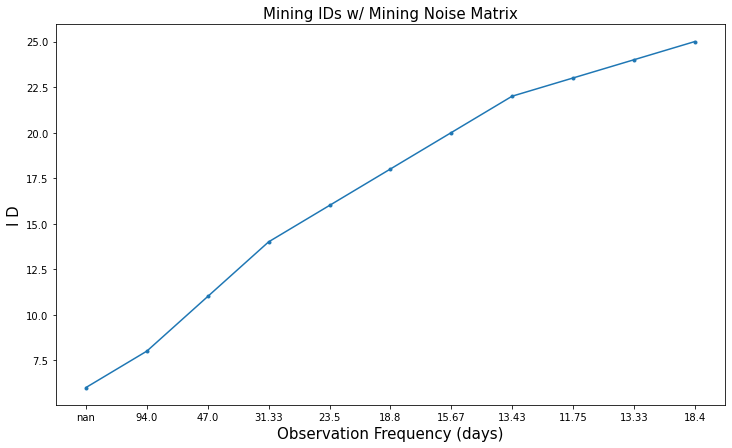

In [209]:
fig = plt.figure(figsize=(12,7));
plt.plot([i['intrinsic_dimension'] for i in ids], marker='.');
plt.title("Mining IDs w/ Mining Noise Matrix", fontsize=15);
plt.xlabel("Observation Frequency (days)", fontsize=15);
plt.xticks(range(0,11), [np.round(i[1],2) for i in series_dates_corrected])
plt.ylabel("I D", fontsize=15);

In [145]:
date_based_outliers = []
ri = 0
for i in range(max(max(outliers), max(usable_indices))):
    if i in outliers:
        # date_based_outliers.append(i-(2215*ri))
        date_based_outliers.append(i%2216)
            
    # if i%2215 == 0 and i != 0:
    #     print("going around")
    #     ri+=1

In [7]:
# outlier detection

In [7]:
def spectral_angle(a, b):
    a, b = np.array(a), np.array(b)
    if a.shape != b.shape:
        raise Exception("shape mismatch")
        
    def l2_norm(x):
        return sum([i**2 for i in x])**0.5
    
    inner = (a.T@b)/(l2_norm(a)*l2_norm(b))
    return np.arccos(inner)

In [8]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indices = np.where(cond_1 | cond_2 | cond_3 | cond_4)

In [9]:
indices = [i for i in range(425) if i not in list(bad_indices[0])]

In [10]:
2216*11

24376

In [11]:
mega_rfl = np.array([])

for date in total_rfls_corrected.keys():
    if len(mega_rfl) == 0:
        mega_rfl = total_rfls_corrected[date]
    else:
        mega_rfl = np.concatenate([mega_rfl, total_rfls_corrected[date]], axis=0)
        
mega_rfl.shape, total_rfls_corrected['20220224'].shape

((24376, 425), (2216, 425))

In [12]:
# GET DISTANCES
ds = mega_rfl[:, indices]
distances = []

# normalize
mean = np.mean(ds, axis=0)
std = np.std(ds, axis=0)
# norm_mean = mean/(np.sum([j**2 for j in mean])**0.5)

for i, pix in enumerate(ds):
    # norm_pix = pix/(np.sum([j**2 for j in pix])**0.5)
    # dist = spectral_angle(norm_mean, norm_pix) # normalization happens within spectral angle
    dist = spectral_angle(mean, pix) # normalization happens within spectral angle
    distances.append((i, dist))

In [36]:
mean_dist = np.mean([m[1] for m in distances])
std_dist = np.nanstd([m[1] for m in distances])
print(mean_dist, std_dist)

z_scores = [abs(d[1]-mean_dist)/std_dist for d in distances]

0.029009937468079408 0.02177807924517563


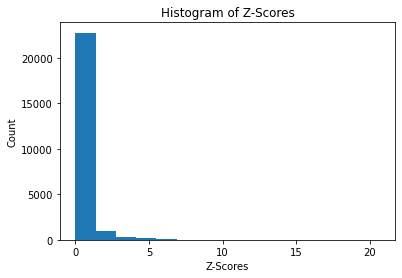

In [37]:
plt.title("Histogram of Z-Scores", fontsize=12);
plt.xlabel("Z-Scores");
plt.ylabel("Count");
plt.hist(z_scores, bins=15);

In [38]:
threshold = 0.5
outliers = [distances[i][0] for i in range(len(z_scores)) if abs(z_scores[i])>threshold]
print(f"Outliers: {len(outliers)} | Total Pixels: {len(z_scores)} | Usable Pixels: {len(z_scores)-len(outliers)}")

Outliers: 10857 | Total Pixels: 24376 | Usable Pixels: 13519


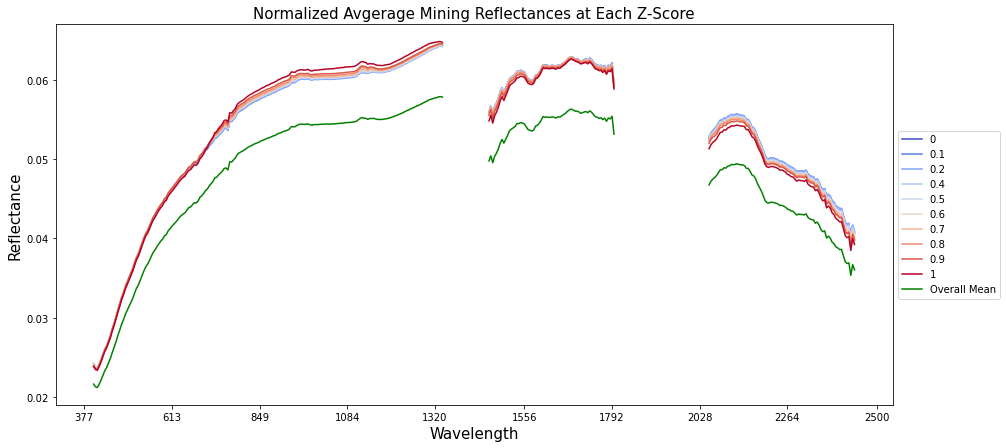

In [43]:
# threshes = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2][:8]
# threshes = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
# threshes = [0, 0.2, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2]
# threshes = [0.7, 0.8, 0.9, 1, 1.1, 1.2]
threshes = [0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
fig = plt.figure(figsize=(15,7))

colors = plt.cm.coolwarm(np.linspace(0,1,len(threshes)))

for c_i, t in enumerate(threshes):
    ol = [distances[i][0] for i in range(len(z_scores)) if np.round(abs(z_scores[i]), 1) == t]
    this_thresh_mean_rfl = np.array([mega_rfl[i] for i in ol])
    
    # if len(this_thresh_mean_rfl) == 0:
        # this_thresh_mean_rfl = np.zeros(425)
        # this_thresh_mean_rfl[bad_indices] = np.nan
    if len(this_thresh_mean_rfl) != 0:
        this_thresh_mean_rfl = np.mean(this_thresh_mean_rfl, axis=0)
        this_thresh_mean_rfl[bad_indices] = np.nan
        this_thresh_mean_rfl = this_thresh_mean_rfl/(sum([i**2 for i in this_thresh_mean_rfl if not np.isnan(i)])**0.5)
        plt.plot(this_thresh_mean_rfl, c = colors[c_i], label = str(t));

sm = np.array(np.mean(mega_rfl, axis=0)/(sum([i**2 for i in np.mean(mega_rfl, axis=0) if not np.isnan(i)])**0.5))
sm[bad_indices] = np.nan
plt.plot(sm, c='green', label="Overall Mean");
n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]
plt.xticks(x_t0, x_t1)
plt.title("Normalized Avgerage Mining Reflectances at Each Z-Score", fontsize=15);
plt.xlabel("Wavelength", fontsize=15);
plt.ylabel("Reflectance", fontsize=15);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

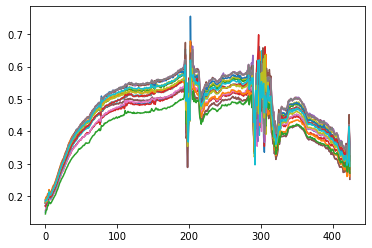

In [16]:
ol = [distances[i][0] for i in range(len(z_scores)) if np.round(abs(z_scores[i]), 1) == 0.5]
this_thresh_mean_rfl = np.array([mega_rfl[i] for i in ol])
plt.plot(this_thresh_mean_rfl[80:100,:].T);

In [17]:
usable_indices = [i for i in range(mega_rfl.shape[0]) if i not in outliers]

In [18]:
mega_rfl_cleaned = mega_rfl[usable_indices]
with open("/home/makiper/Notebooks/true_mining_rfls_final.pickle", "wb") as f:
    pickle.dump(mega_rfl_cleaned, f)

In [19]:
mega_rfl_cleaned.shape

(13519, 425)

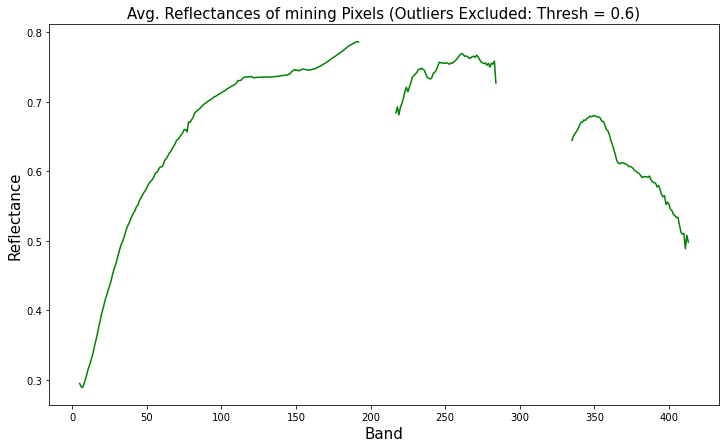

In [20]:
fig = plt.figure(figsize=(12,7))

sm = np.mean(mega_rfl_cleaned.copy(), axis=0)
sm[bad_indices] = np.nan
sm2 = np.mean(mega_rfl.copy(), axis=0)
sm2[bad_indices] = np.nan
plt.plot(sm, c='green');
# plt.plot(sm2, c='orange');
plt.title("Avg. Reflectances of mining Pixels (Outliers Excluded: Thresh = 0.6)", fontsize=15);
plt.xlabel("Band", fontsize=15);
plt.ylabel("Reflectance", fontsize=15);

In [21]:
"""Develop Covariance Matrix"""

'Develop Covariance Matrix'

In [22]:
usable_mega = mega_rfl_cleaned[:, indices]
mega_rfl_clean_norm = np.array([j/(sum([i**2 for i in j])**0.5) for j in usable_mega])

In [23]:
mean_mega_clean_norm = np.mean(mega_rfl_clean_norm, axis=0)

In [24]:
noise = np.array([i-mean_mega_clean_norm for i in mega_rfl_clean_norm])

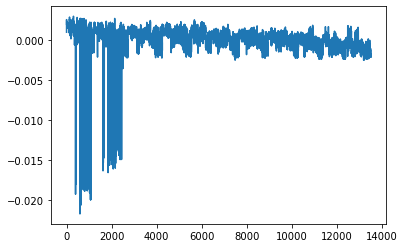

In [66]:
plt.plot(noise[:, 234]);

In [77]:
high_var = np.where(abs(noise[:, 234]) > 3*np.std(noise[:, 234]))[0]

In [80]:
noise_2 = np.delete(noise, high_var, axis=0)

In [86]:
noise_mat_2 = np.cov(noise_2, rowvar=False)

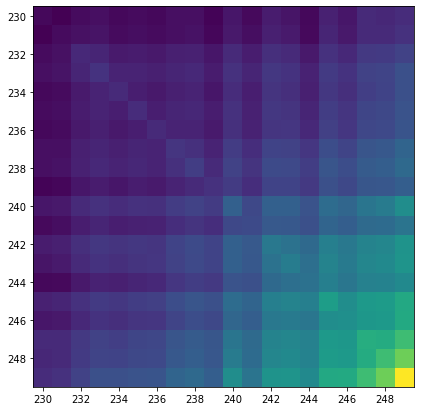

In [87]:
fig = plt.figure(figsize=(12,7))
start = 230
end = 250
plt.imshow(noise_mat_2[start:end, start:end]);
plt.xticks(range(0, end-start, 2), range(start, end, 2));
plt.yticks(range(0, end-start, 2), range(start, end, 2));

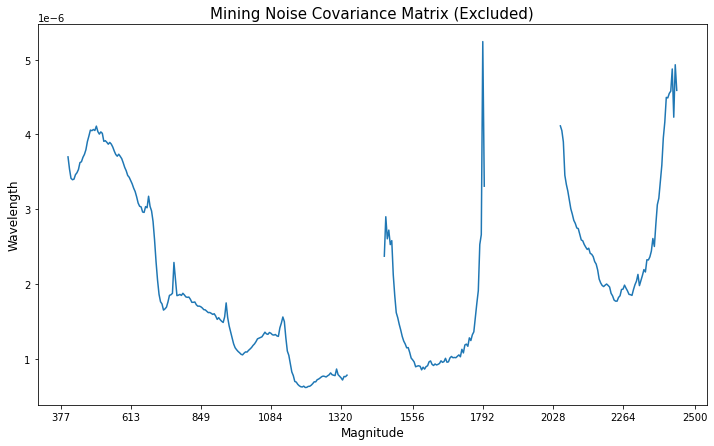

In [92]:
plot_elements_2 = []
noise_index = 0
for i in range(425):
    if i in indices:
        plot_elements_2.append(np.diag(noise_mat_2)[noise_index])
        noise_index+=1
    else:
        plot_elements_2.append(np.nan)
        
n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]

fig = plt.figure(figsize=(12,7))
plt.plot(plot_elements_2);
plt.xticks(x_t0, x_t1)
plt.title("Mining Noise Covariance Matrix (Excluded)", fontsize=15);
plt.xlabel("Magnitude", fontsize=12);
plt.ylabel("Wavelength", fontsize=12);

In [90]:
with open("/home/makiper/Notebooks/mining_noise_2.pickle", "wb") as f:
    pickle.dump(noise_mat_2, f)

In [25]:
noise_mat = np.cov(noise, rowvar=False)
noise_mat.shape

(335, 335)

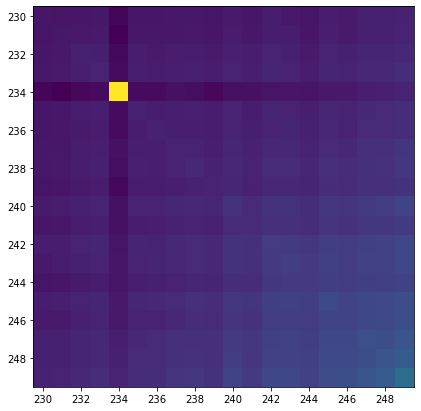

In [57]:
fig = plt.figure(figsize=(12,7))
start = 230
end = 250
plt.imshow(noise_mat[start:end, start:end]);
plt.xticks(range(0, end-start, 2), range(start, end, 2));
plt.yticks(range(0, end-start, 2), range(start, end, 2));

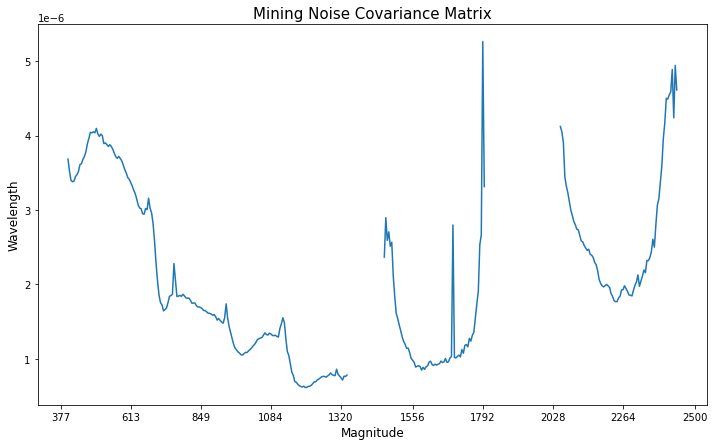

In [91]:
plot_elements = []
noise_index = 0
for i in range(425):
    if i in indices:
        plot_elements.append(np.diag(noise_mat)[noise_index])
        noise_index+=1
    else:
        plot_elements.append(np.nan)
        
n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]

fig = plt.figure(figsize=(12,7))
plt.plot(plot_elements);
plt.xticks(x_t0, x_t1)
plt.title("Mining Noise Covariance Matrix", fontsize=15);
plt.xlabel("Magnitude", fontsize=12);
plt.ylabel("Wavelength", fontsize=12);

In [102]:
noise_mat

array([[3.68324241e-06, 3.58086344e-06, 3.50534281e-06, ...,
        2.41597321e-07, 2.42684846e-07, 1.64919287e-07],
       [3.58086344e-06, 3.52128028e-06, 3.44315908e-06, ...,
        2.29602660e-07, 2.52646963e-07, 1.81216075e-07],
       [3.50534281e-06, 3.44315908e-06, 3.39763626e-06, ...,
        2.37582214e-07, 2.72429267e-07, 2.02102512e-07],
       ...,
       [2.41597321e-07, 2.29602660e-07, 2.37582214e-07, ...,
        4.23826462e-06, 4.47568127e-06, 4.26638630e-06],
       [2.42684846e-07, 2.52646963e-07, 2.72429267e-07, ...,
        4.47568127e-06, 4.94281326e-06, 4.65539377e-06],
       [1.64919287e-07, 1.81216075e-07, 2.02102512e-07, ...,
        4.26638630e-06, 4.65539377e-06, 4.61290453e-06]])

In [103]:
with open("/home/makiper/Notebooks/mining_noise.pickle", "wb") as f:
    pickle.dump(noise_mat, f)

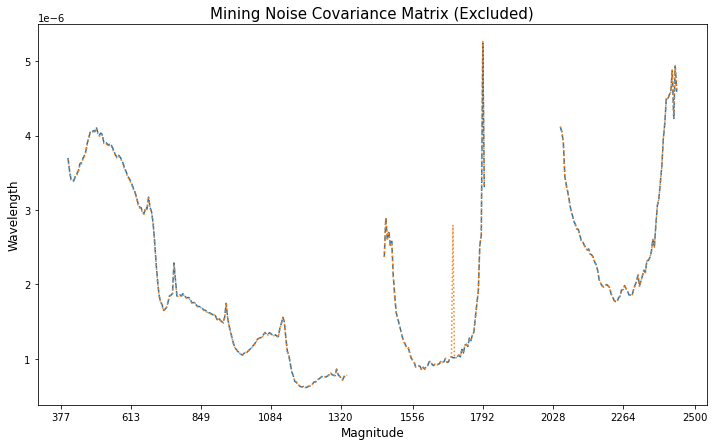

In [101]:
plot_elements_2 = []
noise_index = 0
for i in range(425):
    if i in indices:
        plot_elements_2.append(np.diag(noise_mat_2)[noise_index])
        noise_index+=1
    else:
        plot_elements_2.append(np.nan)
        
plot_elements = []
noise_index = 0
for i in range(425):
    if i in indices:
        plot_elements.append(np.diag(noise_mat)[noise_index])
        noise_index+=1
    else:
        plot_elements.append(np.nan)
        
n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]

fig = plt.figure(figsize=(12,7))
plt.plot(plot_elements_2, linestyle="--");
plt.plot(plot_elements, linestyle=":");
plt.xticks(x_t0, x_t1)
plt.title("Mining Noise Covariance Matrix (Excluded)", fontsize=15);
plt.xlabel("Magnitude", fontsize=12);
plt.ylabel("Wavelength", fontsize=12);

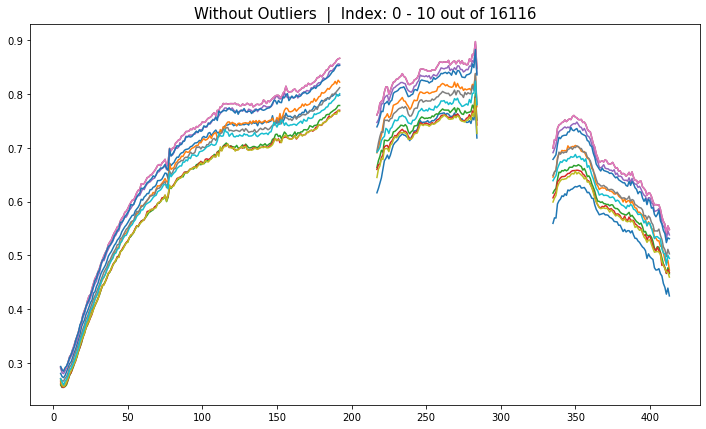

In [29]:
# CONTROLS SELECTION:
condition_choice = 0
threshold = 0.6
start_ind = 0
step = 10
show_average_reflectance = False

end_ind = start_ind+step

outliers = [distances[i][0] for i in range(len(z_scores)) if abs(z_scores[i])>threshold]

wl = np.arange(mega_rfl.shape[1]).astype(np.float32)
wl[bad_indices] = np.nan

conditions = [\
              np.delete(range(0,mega_rfl.shape[0],1), outliers),
              outliers,
              range(0,mega_rfl.shape[0],1)
             ]
condition = conditions[condition_choice]

t = ["Without Outliers", "Outliers Only", "All Rfls"][condition_choice]
t = t + f" (thresh: {threshold})" if condition_choice == 1 else t

fig = plt.figure(figsize=(12,7))
plt.title(f"{t}  |  Index: {start_ind} - {end_ind} out of {mega_rfl[condition,:].shape[0]}", fontsize=15)
plt.plot(wl, mega_rfl[condition,:][start_ind:end_ind+1,:].T);

if show_average_reflectance:
    plt.plot(np.mean(mega_rfl, axis=0))